In [1]:
%pip install pandas 
%pip install mysql-connector-python
%pip install decouple
%pip install pymysql sqlalchemy
%pip install python-dotenv
%pip install numpy



Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import os

import pandas as pd
import numpy as np

import mysql.connector
from sqlalchemy import create_engine
from dotenv import load_dotenv
from datetime import datetime

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator

import scipy.stats as stats
from scipy.stats import zscore


In [3]:
# Load environment variables from .env file (if you're using dotenv)
load_dotenv()

True

In [4]:
username = os.getenv('DB_USERNAME')
password = os.getenv('DB_PASSWORD')
host = os.getenv('DB_HOST')
database = os.getenv('DB_NAME') 

engine = create_engine(f'mysql+pymysql://{username}:{password}@{host}/{database}')

In [5]:
class DatasetLoader:
    def load_data(self, filepath):
        return pd.read_csv(filepath, encoding = "ISO-8859-1", engine='python')

In [6]:

class DataCleaner:
    
    def handle_missing_values(self, data):
        print(data.isnull().sum())  # Count missing values per column
        data = data.dropna()  # Drop rows with any null values
        return data

    def check_header_data_types(self, data, data_types):
        for column, dtype in data_types.items():
            if column in data.columns:
                try:
                    data[column] = data[column].astype(dtype)
                except ValueError as e:
                    print(f"Error converting {column} to {dtype}: {e}")
        return data

    def validate_values(self, data):
        data_types = {
            "InvoiceNo": "object",
            "StockCode": "object",
            "Description": "object",
            "Quantity": "float64",
            "InvoiceDate": "datetime64[ns]",
            "UnitPrice": "float64",
            "CustomerID": "float64",
            "Country": "object"
        }
        
        # Step 1: Fix data types first (may introduce new NaNs)
        data = self.check_header_data_types(data, data_types)
        
        # Step 2: Remove duplicates based on key columns
        data = self.handle_duplicates(data, subset=["InvoiceNo", "StockCode"])
        return data


    def normalise_country_names(self, data):
        replacements = {
            'RSA': 'South Africa',
            'EIRE': 'Ireland'
        }
        data['Country'] = data['Country'].replace(replacements)
        return data


    def handle_duplicates(self, data, subset=None, keep='first'):
        """
        Remove duplicate rows and print a detailed report.
        """
        
        initial_rows = len(data)
        duplicate_mask = data.duplicated(subset=subset, keep=keep)
        duplicate_count = duplicate_mask.sum()
    
        print("\n=== Duplicate Report ===")
        print(f"Initial rows: {initial_rows}")
        print(f"Duplicate rows found: {duplicate_count}")
    
        if duplicate_count > 0:
            print("\nExample duplicate rows:")
            duplicates = data[duplicate_mask].head(2)
            print(duplicates.to_string(index=False))
    
        data_cleaned = data.drop_duplicates(subset=subset, keep=keep)
        final_rows = len(data_cleaned)
        print(f"\nRows after removal: {final_rows}")
        print(f"Total duplicates removed: {initial_rows - final_rows}")
    
        return data_cleaned

    def unique_check(self, data):
        for column in data.columns:
            if data[column].duplicated().any():
                print(f"Warning: Duplicate values found in column {column}")
        return data


    def separate_date_format(self, data):
        df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
        df['Date'] = df['InvoiceDate'].dt.date
        df['Time'] = df['InvoiceDate'].dt.time

    def save_changes(self, data):
        data.to_csv('../dataset/cleaned_data.csv', index=False)
        print("Cleaned data saved successfully!")
        return data



In [7]:
class ExploreData:
    
    def total_revenue(self, data):
        data['TotalSold'] = data['Quantity'] * data['UnitPrice']
        total_revenue = "${:,.2f}".format(data['TotalSold'].sum())
        return total_revenue

    def total_sales_by_country(self, data):
        sales_by_country = data.groupby('Country')['TotalSold'].sum().reset_index()
        sales_by_country = sales_by_country.sort_values(by='TotalSold', ascending=False)
        return sales_by_country

    def singapore(self, data):
        singapore_data = data[data['Country'] == 'Singapore']
        singapore_data = singapore_data[['UnitPrice']].median()        
        return singapore_data

    def average_price_by_country(self, data):
        average_price_by_country = data.groupby('Country')['UnitPrice'].mean().reset_index()
        average_price_by_country = average_price_by_country.rename(columns={'UnitPrice': 'AveragePrice'})
        
        # Visualizing the data using matplotlib
        plt.figure(figsize=(15, 10))
        plt.bar(average_price_by_country['Country'], average_price_by_country['AveragePrice'], color='green')
        plt.xlabel('Country')
        plt.ylabel('Average Price')
        plt.title('Average Price of Products by Country')
        plt.xticks(rotation=90)
        plt.tight_layout()  
        plt.show()
        
        
        return average_price_by_country

    def product_sold_by_country(self, data):
        # Group by Country and sum Quantity
        product_sold_by_country = data.groupby('Country')['Quantity'].sum().reset_index()
        # Rename columns
        product_sold_by_country = product_sold_by_country.rename(columns={'Quantity': 'TotalSold'})
        # Sort values numerically
        product_sold_by_country = product_sold_by_country.sort_values(by='TotalSold', ascending=False)
        # Ensure TotalSold is displayed as an integer
        product_sold_by_country['TotalSold'] = product_sold_by_country['TotalSold'].astype(int)
        
        # Visualizing the data using matplotlib
        plt.figure(figsize=(12, 8))
        plt.bar(product_sold_by_country['Country'], product_sold_by_country['TotalSold'], color='green')
        plt.xlabel('Country')
        plt.ylabel('Total Quantity Sold')
        plt.title('Total Quantity Sold by Country')
        plt.xticks(rotation=90)
        plt.tight_layout()  
        plt.show()
    
        return product_sold_by_country



In [8]:

if __name__ == "__main__":
    # Load your data
    df = pd.read_csv('../dataset/data.csv')

    
    # Instantiate DataCleaner and clean your data
    cleaner = DataCleaner()
    df = cleaner.handle_missing_values(df)
    df = cleaner.validate_values(df)
    df = cleaner.unique_check(df)
    df = cleaner.normalise_country_names(df)

    
    

    

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

=== Duplicate Report ===
Initial rows: 396681
Duplicate rows found: 0

Rows after removal: 396681
Total duplicates removed: 0


In [9]:
    cleaner.save_changes(df)

Cleaned data saved successfully!


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE META,6.0,2010-01-12 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6.0,2010-01-12 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8.0,2010-01-12 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6.0,2010-01-12 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6.0,2010-01-12 08:26:00,3.39,17850.0,United Kingdom
...,...,...,...,...,...,...,...,...
396676,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12.0,2011-09-12 12:50:00,0.85,12680.0,France
396677,581587,22899,CHILDREN'S APRON DOLLY GIRL,6.0,2011-09-12 12:50:00,2.10,12680.0,France
396678,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4.0,2011-09-12 12:50:00,4.15,12680.0,France
396679,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4.0,2011-09-12 12:50:00,4.15,12680.0,France


The total revenue 

In [11]:
    explorer = ExploreData()
    total_revenue = explorer.total_revenue(df)
    print(f"Total Revenue: {total_revenue}")

Total Revenue: $8,246,367.30


The sales by country

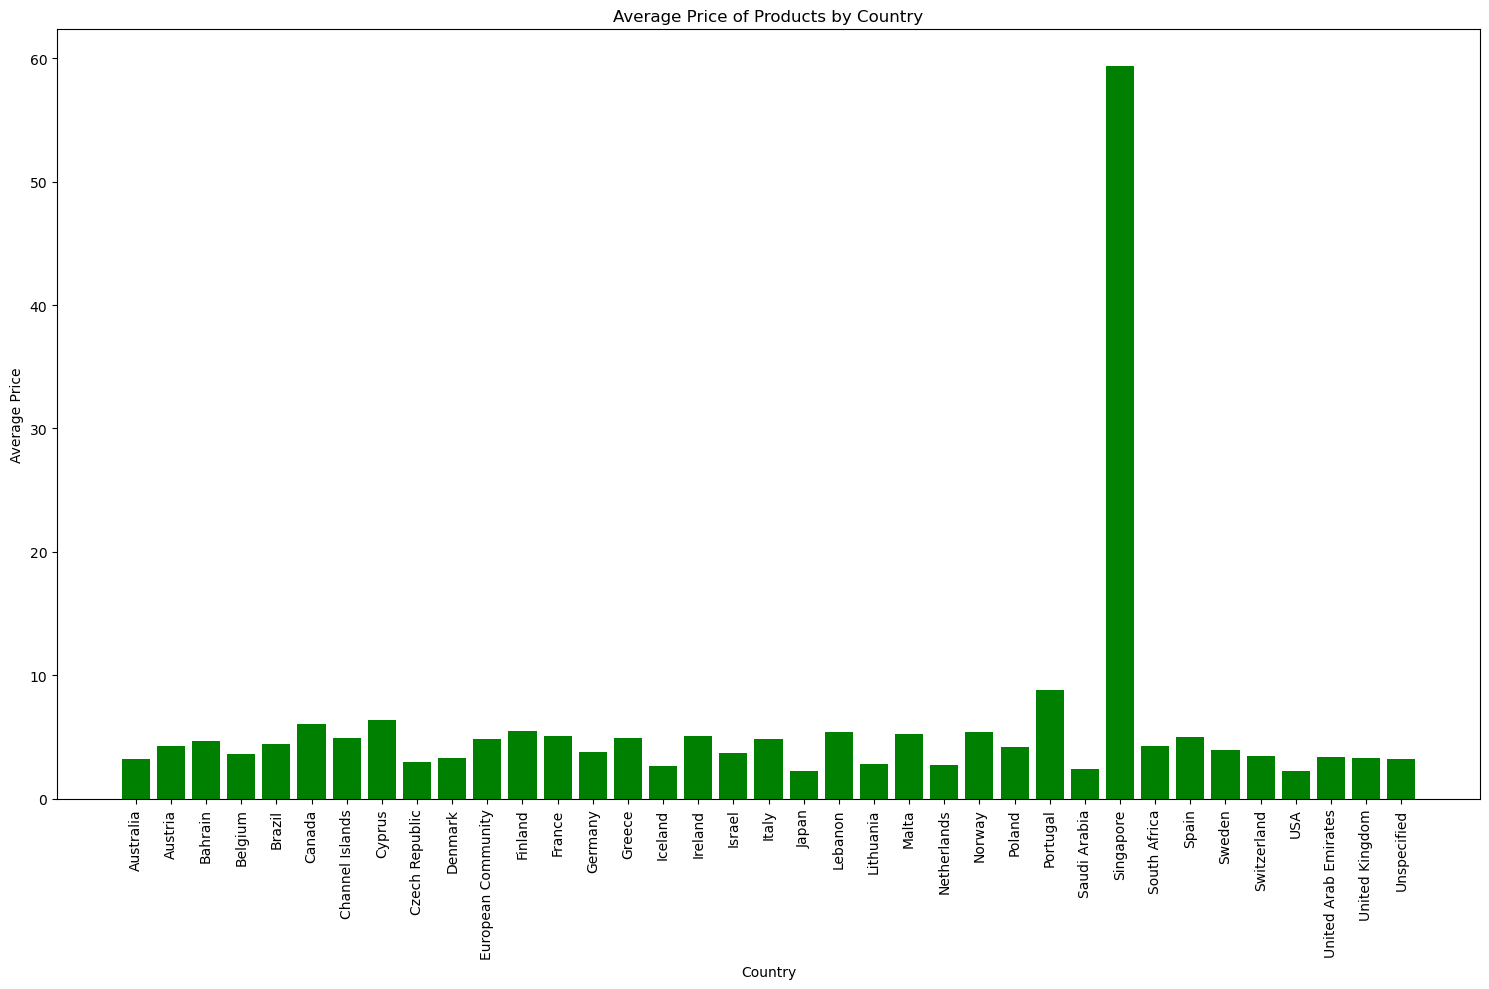

Average Price by Country:
                 Country  AveragePrice
0              Australia      3.217064
1                Austria      4.243192
2                Bahrain      4.644118
3                Belgium      3.644335
4                 Brazil      4.456250
5                 Canada      6.030331
6        Channel Islands      4.936460
7                 Cyprus      6.343229
8         Czech Republic      2.938333
9                Denmark      3.261082
10    European Community      4.820492
11               Finland      5.477815
12                France      5.062260
13               Germany      3.812328
14                Greece      4.885548
15               Iceland      2.644011
16               Ireland      5.111101
17                Israel      3.670648
18                 Italy      4.831121
19                 Japan      2.276145
20               Lebanon      5.387556
21             Lithuania      2.841143
22                 Malta      5.244173
23           Netherlands      2.738317

In [13]:
    avg_price_by_country = explorer.average_price_by_country(df)
    print("Average Price by Country:")
    print(avg_price_by_country)

Total sales by season, month

* the average prices tends to have a huge outlier which might include certain taxes or tariffs being applied on specific products due regulatory reasons
  
Despite Singapore containing outlier but due the rule of consistency, we use the mean price instead of median

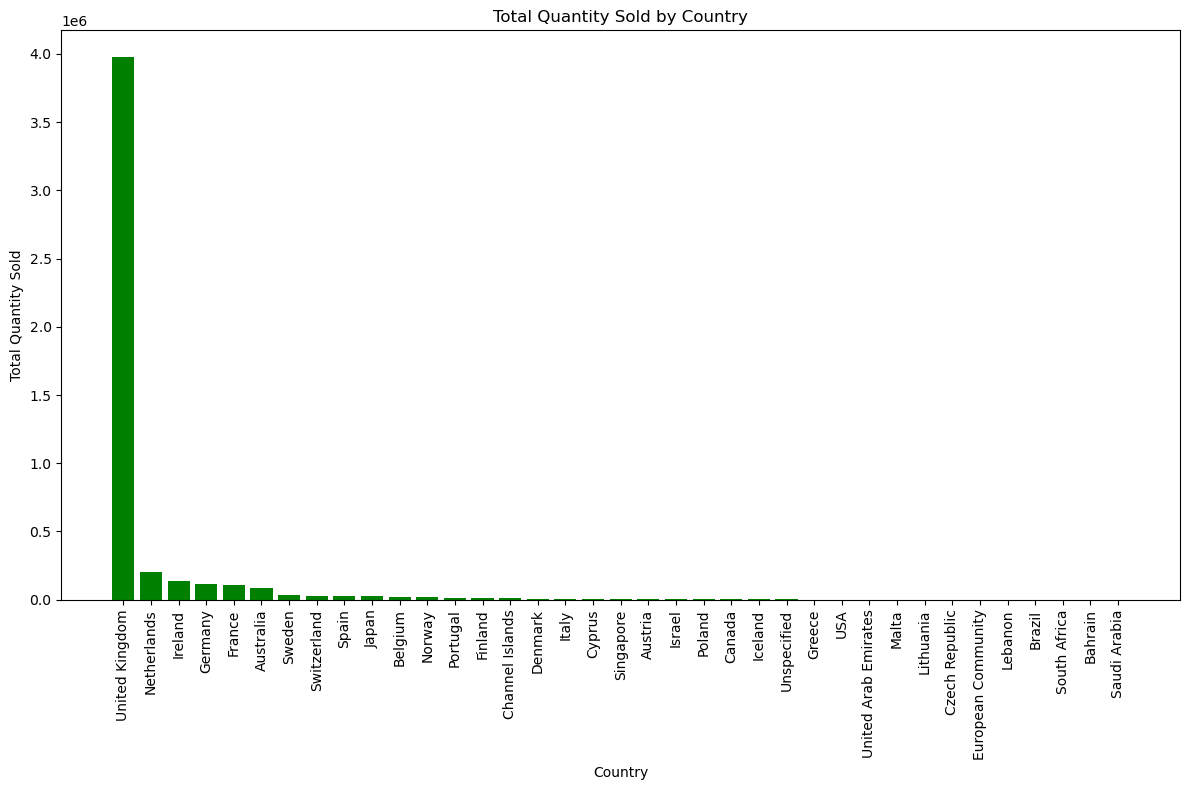

                 Country  TotalSold
35        United Kingdom    3973418
23           Netherlands     200128
16               Ireland     136183
13               Germany     117309
12                France     109694
0              Australia      83635
31                Sweden      35632
32           Switzerland      29777
30                 Spain      26751
19                 Japan      25218
3                Belgium      23152
24                Norway      19244
26              Portugal      15940
11               Finland      10186
6        Channel Islands       9473
9                Denmark       8163
18                 Italy       7999
7                 Cyprus       6280
28             Singapore       5234
1                Austria       4827
17                Israel       3987
25                Poland       3653
5                 Canada       2763
15               Iceland       2458
36           Unspecified       1778
14                Greece       1556
33                   USA    

In [16]:
    products_by_country = explorer.product_sold_by_country(df)
    print(products_by_country)